# Data Setup

In [1]:
import numpy as np
import pandas as pd
import nltk
import data_cleaning as dc
import stock_pricing as sp
import importlib

from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

# Force reload data_cleaning and stock_pricing
importlib.reload(dc)
importlib.reload(sp)

# Prepare the NLTK resources
nltk.download('wordnet')
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()

# Define desired database parameters. Set to -1 to load all data.
database_size = -1

# Optionally force data to be regenerated
force_data_regeneration = False

try:
    # If force_data_regeneration is set, force an exception to reload the data
    if force_data_regeneration:
        print('Forcing data regeneration.')
        raise ValueError('Forcing data regeneration.')
    
    # Load the preprocessed data if it exists
    df = pd.read_csv('./data/stockerbot-export-preprocessed.csv')
    
    # If dataframe is not expected size, reload the data
    if database_size != -1 and len(df) > database_size:
        df = df.sample(n=database_size)
    elif database_size != -1 and len(df) < database_size:    
        print('Preprocessed file is not the expected size. Reloading data.')
        raise ValueError('Preprocessed file is not the expected size.')
    
    print('Preprocessed file found and loaded.')
except (FileNotFoundError, ValueError):
    # Load dataset with stock data
    df = sp.preprocess_nasdaq_df('./data/stockerbot-export', database_size)

    # Add sentiment column with TextBlob if it doesn't exist
    df['tweet_polarity'] = df['text'].apply(lambda tweet: TextBlob(tweet).sentiment.polarity)
    df['tweet_subjectivity'] = df['text'].apply(lambda tweet: TextBlob(tweet).sentiment.subjectivity)

    # Apply preprocessing to the 'tweet' column
    df['preprocessed_tweet'] = df['text'].apply(lambda tweet: dc.preprocess_tweet(tweet, lemmatizer))
        
    # Save the preprocessed data
    df.to_csv('./data/stockerbot-export-preprocessed.csv', index=False)
    print('File preprocessing completed and saved.')

# Display the preprocessed dataframe
pd.set_option('display.max_colwidth', None)
print(f"Dataframe shape: {df.shape}")
display(df.head(5))

Preprocessed file found and loaded.
Dataframe shape: (22961, 17)


[nltk_data] Downloading package wordnet to /Users/seby/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/seby/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,text,timestamp,source,symbols,company_names,url,verified,month,day,year,Price Day Before Tweet,Price Day of Tweet,Price Day After Tweet,tweet_polarity,tweet_subjectivity,preprocessed_tweet
0,1019696670777503700,VIDEO: “I was in my office. I was minding my own business...” –David Solomon tells $GS interns how he learned he wa… https://t.co/QClAITywXV,2018-07-18 21:33:26,GoldmanSachs,GS,The Goldman Sachs,https://twitter.com/i/web/status/1019696670777503745,True,7,18,2018,202.197403,202.389938,200.980850,0.600000,1.000000,"['video', 'office', 'minding', 'business', '–david', 'solomon', 'tell', '$GS', 'intern', 'learned', 'wa…', 'https://t.co/QClAITywXV']"
1,1019709091038548000,The price of lumber $LB_F is down 22% since hitting its YTD highs. The Macy's $M turnaround is still happening.… https://t.co/XnKsV4De39,2018-07-18 22:22:47,StockTwits,M,Macy's,https://twitter.com/i/web/status/1019709091038547968,True,7,18,2018,29.254164,29.751337,30.745680,-0.155556,0.288889,"['price', 'lumber', '$LB_F', '22', 'since', 'hitting', 'ytd', 'high', 'macy', '$M', 'turnaround', 'still', 'https://t.co/XnKsV4De39']"
2,1019711413798035500,Who says the American Dream is dead? https://t.co/CRgx19x7sA,2018-07-18 22:32:01,TheStreet,AIG,American,https://buff.ly/2L3kmc4,True,7,18,2018,46.698978,47.057472,45.964901,-0.100000,0.200000,"['say', 'american', 'dream', 'dead', 'https://t.co/CRgx19x7sA']"
3,1019718460287389700,How satellites avoid attacks and space junk while circling the Earth https://t.co/aHzIV3Lqp5 #paid @Oracle https://t.co/kacpqZWiDJ,2018-07-18 23:00:01,Forbes,ORCL,Oracle,http://on.forbes.com/6013DqDDU,True,7,18,2018,44.556103,44.319199,44.136963,0.000000,0.000000,"['satellite', 'avoid', 'attack', 'space', 'junk', 'circling', 'earth', 'https://t.co/aHzIV3Lqp5', 'paid', '@Oracle', 'https://t.co/kacpqZWiDJ']"
4,1019720723441635300,Senate wants emergency alerts to go out through Netflix Spotify etc. https://t.co/23yy3whBlc by @grg,2018-07-18 23:09:00,TechCrunch,NFLX,Netflix,https://tcrn.ch/2L8DsgT,True,7,18,2018,379.480011,375.130005,364.230011,0.200000,0.100000,"['senate', 'want', 'emergency', 'alert', 'go', 'netflix', 'spotify', 'etc', 'https://t.co/23yy3whBlc', '@grg']"


## Testing/Training Data

In [3]:
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
importlib.reload(dc)

# Define the scalers
tfidf_vectorizer = TfidfVectorizer()
onehot_encoder = OneHotEncoder()
scaler = StandardScaler()

# Define the features and target variable
text_column = 'preprocessed_tweet'
categorical_columns = ['source', 'symbols']
numerical_columns = ['tweet_polarity', 'tweet_subjectivity', 'Price Day Before Tweet', 'Price Day of Tweet']
target_column = 'Price Day After Tweet'

# Prepare the features and target variable
X, y = dc.prepare_features(df, text_column, categorical_columns, numerical_columns, target_column, tfidf_vectorizer, onehot_encoder, scaler)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
from sklearn.linear_model import LinearRegression
import model_util as mu

# Force retrain the models
force_retrain = False

# Load the pretrained Ridge and Lasso models
ridge_model = mu.load_model(X_train, y_train, './models/ridge_model.pkl', 'RIDGE', force_retrain)
lasso_model = mu.load_model(X_train, y_train, './models/lasso_model.pkl', 'LASSO', force_retrain)
random_forest_model = mu.load_model(X_train, y_train, './models/random_forest_model.pkl', 'RANDOM FOREST', force_retrain)

# Train linear regression model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)

Training RIDGE model...
Fitting 5 folds for each of 13 candidates, totalling 65 fits
[CV] END ........................................alpha=1e-05; total time=  21.8s
[CV] END ........................................alpha=1e-05; total time=  24.7s
[CV] END ........................................alpha=1e-05; total time=  25.0s
[CV] END ........................................alpha=1e-06; total time=  34.2s
[CV] END .......................................alpha=0.0001; total time=   9.8s
[CV] END ........................................alpha=1e-06; total time=  38.1s
[CV] END ........................................alpha=1e-06; total time=  40.2s
[CV] END ........................................alpha=1e-06; total time=  40.5s
[CV] END ........................................alpha=1e-06; total time=  41.7s
[CV] END ........................................alpha=0.001; total time=   2.8s
[CV] END .......................................alpha=0.0001; total time=   9.5s
[CV] END ...............

/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 37082.98588111325, tolerance: 16661.31742188937
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END ........................................alpha=1e-05; total time=10.9min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38180.97669740653, tolerance: 16778.869959039675
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END ........................................alpha=1e-05; total time=11.1min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 39380.38271869171, tolerance: 17050.88362620761
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END ........................................alpha=1e-05; total time=11.1min
[CV] END ........................................alpha=1e-06; total time=11.7min
[CV] END ........................................alpha=1e-06; total time=11.7min
[CV] END ........................................alpha=1e-06; total time=11.8min
[CV] END ........................................alpha=1e-06; total time=11.8min
[CV] END ........................................alpha=1e-06; total time=11.8min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28601.501137425592, tolerance: 16661.31742188937
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END .......................................alpha=0.0001; total time= 9.6min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22824.54439136282, tolerance: 16661.31742188937
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END ........................................alpha=0.001; total time= 9.3min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28814.596182293535, tolerance: 17050.88362620761
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END .......................................alpha=0.0001; total time= 9.7min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29172.28284442372, tolerance: 17476.724449549372
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END .......................................alpha=0.0001; total time= 9.6min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 28968.019685620544, tolerance: 16778.869959039675
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END .......................................alpha=0.0001; total time= 9.7min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29275.244748649406, tolerance: 17174.58016689344
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END .......................................alpha=0.0001; total time= 9.7min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40504.0426481704, tolerance: 17476.724449549372
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END ........................................alpha=1e-05; total time=10.8min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 38992.4052536361, tolerance: 17174.58016689344
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END ........................................alpha=1e-05; total time=10.9min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23450.845927315877, tolerance: 17050.88362620761
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END ........................................alpha=0.001; total time= 9.4min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23213.485293195612, tolerance: 16778.869959039675
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END ........................................alpha=0.001; total time= 9.4min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24365.812674705685, tolerance: 17476.724449549372
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END ........................................alpha=0.001; total time= 9.3min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22001.085193571103, tolerance: 16661.31742188937
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END .........................................alpha=0.01; total time= 9.2min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23749.63415571096, tolerance: 17174.58016689344
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END ........................................alpha=0.001; total time= 9.4min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22968.129485432142, tolerance: 17050.88362620761
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END .........................................alpha=0.01; total time= 9.3min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22740.17333018374, tolerance: 16778.869959039675
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END .........................................alpha=0.01; total time= 9.3min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23235.62976253124, tolerance: 17174.58016689344
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END .........................................alpha=0.01; total time= 9.3min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24052.931909784194, tolerance: 17476.724449549372
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END .........................................alpha=0.01; total time= 9.2min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23557.674609042973, tolerance: 16661.31742188937
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END ..........................................alpha=0.1; total time= 9.2min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23909.27258980769, tolerance: 16778.869959039675
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END ..........................................alpha=0.1; total time= 9.3min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24256.612791294763, tolerance: 17050.88362620761
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END ..........................................alpha=0.1; total time= 9.4min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25121.047580780672, tolerance: 17476.724449549372
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END ..........................................alpha=0.1; total time= 9.2min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24497.82941661997, tolerance: 17174.58016689344
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END ..........................................alpha=0.1; total time= 9.3min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23259.128923272154, tolerance: 16661.31742188937
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END ..........................................alpha=1.0; total time= 9.2min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23781.591056676763, tolerance: 17050.88362620761
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END ..........................................alpha=1.0; total time= 9.3min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23676.98660421653, tolerance: 16778.869959039675
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END ..........................................alpha=1.0; total time= 9.3min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24030.957298413254, tolerance: 17174.58016689344
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END ..........................................alpha=1.0; total time= 9.4min
[CV] END ........................................alpha=100.0; total time=   1.3s


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24749.885187616135, tolerance: 17476.724449549372
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END ..........................................alpha=1.0; total time= 9.2min
[CV] END ........................................alpha=100.0; total time=   1.3s


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20098.435734533006, tolerance: 16661.31742188937
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END .........................................alpha=10.0; total time= 9.3min
[CV] END .......................................alpha=1000.0; total time=   0.7s
[CV] END .......................................alpha=1000.0; total time=   0.7s
[CV] END .......................................alpha=1000.0; total time=   0.7s
[CV] END .......................................alpha=1000.0; total time=   0.8s
[CV] END .......................................alpha=1000.0; total time=   0.6s
[CV] END ......................................alpha=10000.0; total time=   0.7s
[CV] END ......................................alpha=10000.0; total time=   0.7s


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18935.229582323227, tolerance: 17050.88362620761
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END .........................................alpha=10.0; total time= 9.3min
[CV] END ......................................alpha=10000.0; total time=   0.7s
[CV] END ......................................alpha=10000.0; total time=   0.7s
[CV] END ......................................alpha=10000.0; total time=   0.7s
[CV] END .....................................alpha=100000.0; total time=   0.7s
[CV] END .....................................alpha=100000.0; total time=   0.6s
[CV] END .....................................alpha=100000.0; total time=   0.6s
[CV] END .....................................alpha=100000.0; total time=   0.7s
[CV] END .....................................alpha=100000.0; total time=   0.6s
[CV] END ....................................alpha=1000000.0; total time=   0.7s
[CV] END ....................................alpha=1000000.0; total time=   0.7s
[CV] END ....................................alpha=1000000.0; total time=   0.7s
[CV] END ...................

/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20870.84107992309, tolerance: 16778.869959039675
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END .........................................alpha=10.0; total time= 9.3min


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19439.51699142158, tolerance: 17174.58016689344
  model = cd_fast.sparse_enet_coordinate_descent(
/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 20972.21586932894, tolerance: 17476.724449549372
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END .........................................alpha=10.0; total time= 9.3min
[CV] END .........................................alpha=10.0; total time= 9.2min
[CV] END ........................................alpha=100.0; total time= 3.0min
[CV] END ........................................alpha=100.0; total time= 4.6min
[CV] END ........................................alpha=100.0; total time=44.7min
LASSO model trained and saved.
Training RANDOM FOREST model...
Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 36755.03154865982, tolerance: 21285.744088112515
  model = cd_fast.sparse_enet_coordinate_descent(


[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=16.0min
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=16.0min
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=16.0min
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=16.0min
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=16.0min
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=17.1min
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=17.1min
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=17.1min
[CV] END max_depth=None, max_

LinearRegression()

## Model Evaluation

In [5]:
importlib.reload(mu)

# Specify the models to evaluate
models = [linear_reg_model, random_forest_model, ridge_model, lasso_model]
model_names = ['Linear Regression', 'Random Forest', 'Ridge Regression', 'Lasso Regression']

# Evaluate the models
mae_scores, mse_scores, rmse_scores, r2_scores = [], [], [], []
for model in models:
    mae, mse, rmse, r2 = mu.evaluate_model(model, X_test, y_test)
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/seby/Desktop/School/2024_Spring/cs4400/final_project/myenv/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/seby/Desktop/School/2024_Spring/cs4400/final_pro

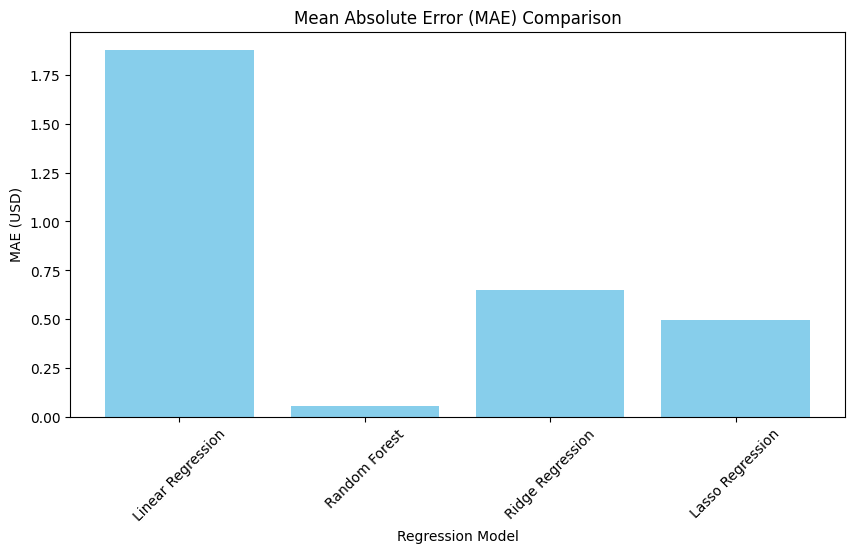

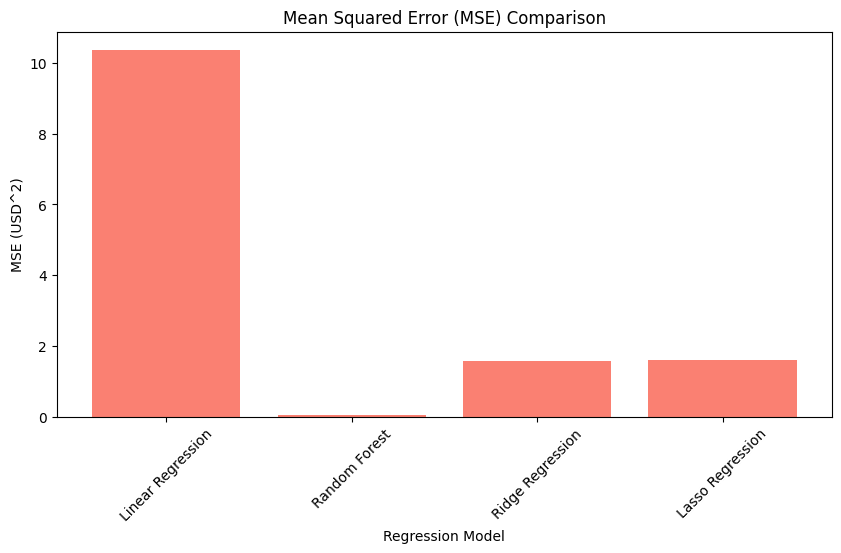

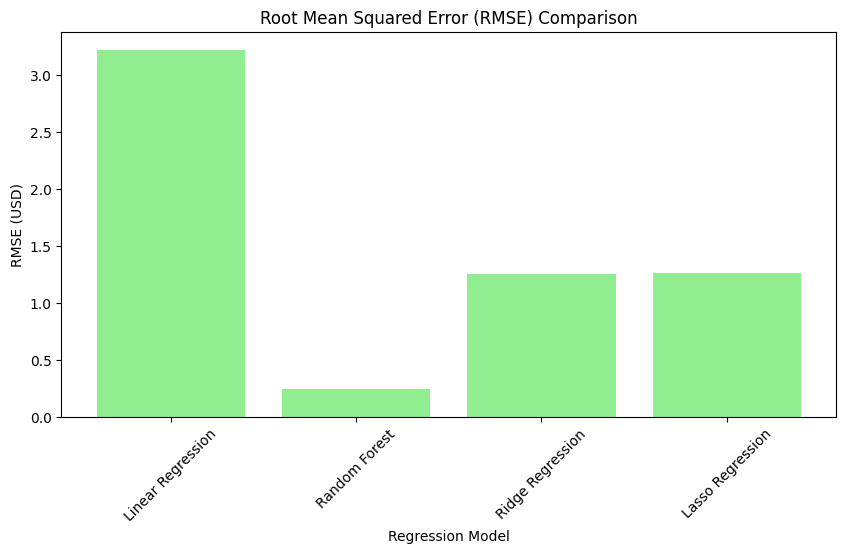

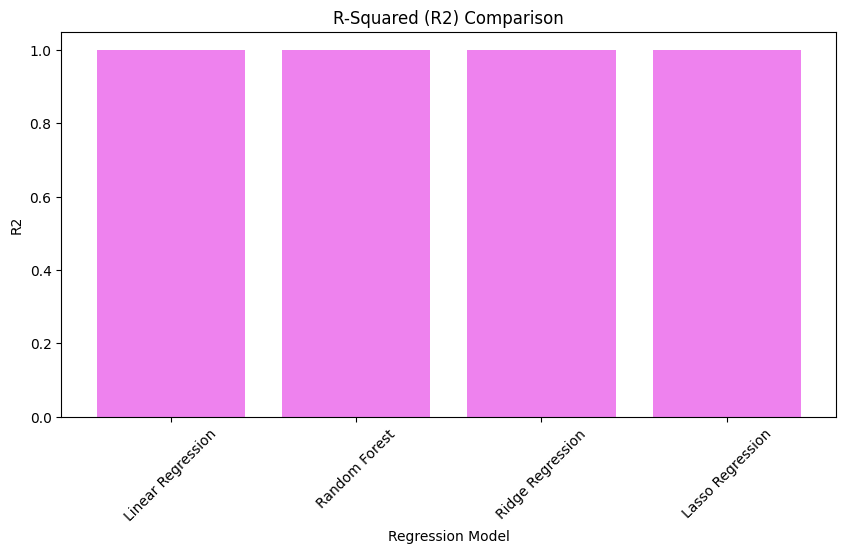

In [6]:
importlib.reload(mu)

# Plotting MAE
mu.plot_metric('Mean Absolute Error (MAE) Comparison', model_names, mae_scores, 'skyblue', 'Regression Model', 'MAE (USD)')

# Plotting MSE
mu.plot_metric('Mean Squared Error (MSE) Comparison', model_names, mse_scores, 'salmon', 'Regression Model', 'MSE (USD^2)')

# Plotting RMSE
mu.plot_metric('Root Mean Squared Error (RMSE) Comparison', model_names, rmse_scores, 'lightgreen', 'Regression Model', 'RMSE (USD)')

# Plotting R2
mu.plot_metric('R-Squared (R2) Comparison', model_names, r2_scores, 'violet', 'Regression Model', 'R2')

## User Evluation

In [7]:
# Find all users with more than 10 tweets
user_tweets = df['source'].value_counts()
user_tweets = user_tweets[user_tweets > 10]

# Split the df dataframe into unique dataframes for each unique user in the 'source' column
user_dataframes = {}
for user, data in df.groupby('source'):
    if user in user_tweets:
        user_dataframes[user] = data.copy()

In [8]:
# Run predictions for each user
user_predictions = {}
for user, user_df in user_dataframes.items():
    # Prepare the features and target variable
    X_user, y_user = dc.prepare_features(user_df, text_column, categorical_columns, numerical_columns, target_column, tfidf_vectorizer, onehot_encoder, scaler)
    
    # Predict the target variable
    for model in models:
        user_predictions[user][model]['predicted'] = model.predict(X_user)
        user_predictions[user][model]['accuracy'] = model.score(X_user, y_user)

ValueError: X has 267 features, but LinearRegression is expecting 41948 features as input.